А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана

Задача

1.Запустите A/A-тест

2.Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000).

3.Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента (подсказка: найдите аномалию в версии приложения)

4.Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста

In [19]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

In [20]:
sns.set(
    font_scale = 2, 
    style = "whitegrid", 
    rc = {'figure.figsize':(12,8)})

In [21]:
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-m-tulnikov-27/STATISTIKA/hw_aa.csv', sep = ';',index_col= 0)
df.head()

,uid,experimentVariant,version,purchase
1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


experimentVariant – вариант эксперимента

version – версия приложения

purchase – факт покупки

In [45]:
var_1 = df.query('experimentVariant == 1').purchase
var_0 = df.query('experimentVariant == 0').purchase

In [ ]:
#df[df.experimentVariant == 1]['purchase']
#df[df.experimentVariant == 0]['purchase']

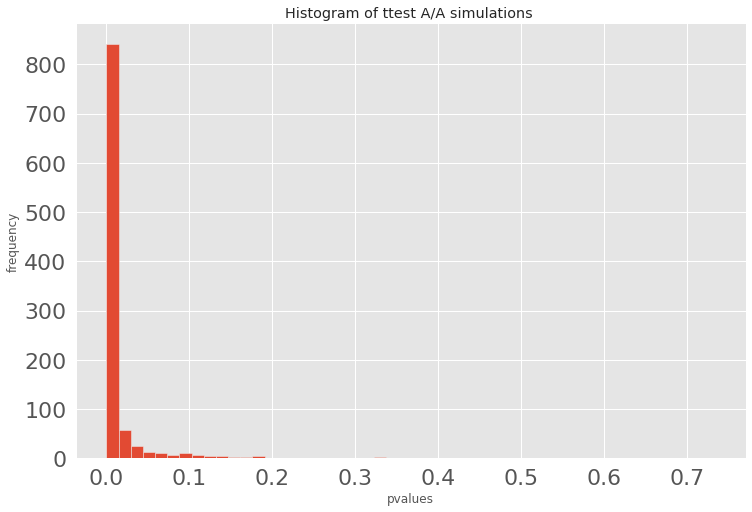

0.93

In [46]:
n = 100000
simulations = 1000
n_s = 1000
res = []


# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = var_1.sample(n_s, replace = False).values
    s2 = var_0.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

По резульатат тестирования видим, что в 93% случаях мы получаем стат.значимые различия, так быть не должно, т.к группы А/B теста не могут отличаться друг от друга, они должны быть одинаковыми. 

Могу предположить, что тот, кто присваивает пользователю experimentVariant допустил ошибку!
Подумаем, почему это произошло...

In [35]:
df.version.value_counts()

v2.8.0      82835
v2.9.0      23954
v3.8.0.0    11804
v3.7.4.0     8425
Name: version, dtype: int64

In [36]:
df.experimentVariant.value_counts()

1    63916
0    63102
Name: experimentVariant, dtype: int64

In [34]:
df.groupby('experimentVariant', as_index=False) \
.agg({'purchase': 'mean'})

,experimentVariant,purchase
0,0,0.023945
1,1,0.053242


Видим, что конверсия группах различается, посмотрим внимательней

In [40]:
df.groupby(['experimentVariant', 'version'], as_index=False) \
.agg({'purchase': 'mean', 'uid': 'count'})

,experimentVariant,version,purchase,uid
0,0,v2.8.0,0.000993,41283
1,0,v2.9.0,0.074658,11921
2,0,v3.7.4.0,0.059943,4204
3,0,v3.8.0.0,0.057604,5694
4,1,v2.8.0,0.045606,41552
5,1,v2.9.0,0.071304,12033
6,1,v3.7.4.0,0.063018,4221
7,1,v3.8.0.0,0.062848,6110


Посмотрели на кол-во пользователей по группам и можем сделать вывод, что сплитование работает хорошо, в то время как конверсия в некоторых версиях отличается в 45 раз между эксперентальными группами, на довольно большой выборке.

Это значит, что в эксперементальную группу 0 версии попадают такие пользователи v2.8.0 у которых конверсия менее 1%, а в эксперементальную группу 1 той же версии попадают пользователи с конверсией в 4,5%

In [41]:
0.045606 / 0.000993

45.927492447129914

Попробуем взять только тех пользователей которые не используют версию v2.8.0

Наши подозрения, что система сплитования очень сильно поломалась для пользователь использовавших версию v2.8.0

In [51]:
var_1_1 = df.query('experimentVariant == 1').query('version != "v2.8.0"').purchase
var_0_0 = df.query('experimentVariant == 0').query('version != "v2.8.0"').purchase

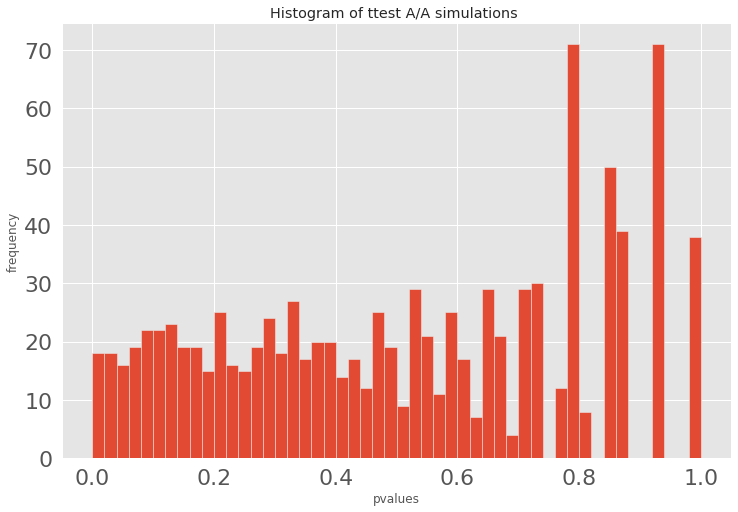

0.046

In [54]:
n = 100000
simulations = 1000
n_s = 1000
res = []


for i in tqdm(range(simulations)):
    s1 = var_1_1.sample(n_s, replace = False).values
    s2 = var_0_0.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1])

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# FPR не сойдется
sum(np.array(res) <0.05) / simulations

После симуляции наш с вами FPR(False positive rate) приблизительно совпал с 5% и это означает, что мы статистически доказали, что это различие в 45 раз конверсии у пользователей использоваваших версию v2.8.0 портило нам всю симуляцию.